In [2]:
root = '../'

import os
from skimage import io, transform
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import mask_rcnn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

In [4]:
# Basic settings
from easydict import EasyDict as edict

cfg = []

torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()
args.batch_size = 1
args.lr = 1e-4
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 10
args.tensorboard = False
args.gpu = True
args.train_portion = 0.7

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

In [5]:
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "{str(result_dir)}" --samples_per_plugin images=100

In [6]:
def draw_image(image, bbs):
    if (torch.is_tensor(image)):
        image = np.array(image.tolist()).transpose((1, 2, 0))
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

class FitVidDataset(Dataset):
    """ FitVid Dataset"""
    
    def __init__(self, img_data, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.img_data = img_data
        self.img_filenames = list(self.img_data.keys())
    
    def __len__(self):
        return len(self.img_filenames)

    def show_image(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = self.img_filenames[idx]
        img_dir = os.path.join(self.root_dir, filename)
        
        image = io.imread(img_dir)
        draw_image(image, self.img_data[filename]['bbs'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = self.img_filenames[idx]
        img_dir = os.path.join(self.root_dir, filename)
        image = io.imread(img_dir)

        bbs = self.img_data[filename]['bbs']

        sample = {
            'image' : image,
            'labels' : bbs,
        }
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [78]:
def draw_bbs(shape, bbs):
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())
    if (torch.is_tensor(shape)):
        [h, w] = np.array(shape.tolist())
        shape = (h, w)
    
    h, w = shape
    fig, ax = plt.subplots(1)
    background=patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor='b', facecolor='black')
    ax.add_patch(background)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.autoscale(True, 'both')
    plt.show()
    return

class BBSlideDeckDataset(Dataset):
    """ Slide Deck Dataset but with Bounding Boxes"""
    def __init__(self, slide_deck_data, transform=None):
        self.transform = transform

        self.slide_deck_data = slide_deck_data
        self.slide_deck_ids = list(self.slide_deck_data.keys())
    
    def __len__(self):
        return len(self.slide_deck_ids)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        slide_deck_id = self.slide_deck_ids[idx]
        (h, w) = self.slide_deck_data[slide_deck_id]["shape"]
        slides = []
        max_len_bbs = 0
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            if len(slide) > max_len_bbs:
                max_len_bbs = len(slide)
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            np_slide = np.zeros((max_len_bbs, 5))
            for i, bb in enumerate(slide):
                np_slide[i] = bb
            slides.append(np_slide)

        ref_slide = slides[0]
        slide_deck = slides[1:]
        sample = {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": np.asarray(slide_deck)
        }

        if self.transform:
            sample = self.transform(sample)
        return sample


In [79]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        labels = labels * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return {'image': img, 'labels': labels}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        labels = labels - np.array([left, top, 0, 0, 0]).T

        return {'image': image, 'labels': labels}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}

In [123]:
class RescaleBB(object):
    """Rescale the bounding boxes in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def _resize_single_slide(self, slide, original_shape, new_shape):
        h, w = original_shape
        new_h, new_w = new_shape
        slide = slide * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return slide

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        slide_deck = sample["slide_deck"]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        ref_slide = self._resize_single_slide(ref_slide, (h, w), (new_h, new_w))
        for i, slide in enumerate(slide_deck):
            slide_deck[i] = self._resize_single_slide(slide, (h, w), (new_h, new_w))

        return {
            "shape": (new_h, new_w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class LeaveN(object):
    def __init__ (self, N):
        self.N = N

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        slide_deck = sample["slide_deck"]

        np.random.shuffle(slide_deck)

        if slide_deck.shape[0] > self.N:
            slide_deck = np.delete(slide_deck, range(self.N, slide_deck.shape[0]), 0)

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class ShuffleRefSlide(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        slide_deck = sample["slide_deck"]
        
        slide_deck = np.vstack((slide_deck, ref_slide[None, :]))
        np.random.shuffle(slide_deck)
        slide_deck = slide_deck.tolist()
        ref_slide = np.asarray(slide_deck.pop())
        slide_deck = np.asarray(slide_deck)

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class ShuffleSlideDeck(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        slide_deck = sample["slide_deck"]
        np.random.shuffle(slide_deck)
        
        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class ToTensorBB(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        slide_deck = sample["slide_deck"]
        return {
            'shape': torch.tensor([h, w]),
            'ref_slide': torch.from_numpy(ref_slide),
            'slide_deck': torch.from_numpy(slide_deck)
        }

In [124]:
BB_TYPES = [
    'title',
    'header',
    'text box',
    'footer',
    'picture',
    'instructor',
    'diagram',
    'table',
    'figure',
    'handwriting',
    'chart',
    'schematic diagram',
]

def process_slide_deck_dataset(all_dataset):
    slide_deck_data = {}
    for entrance in all_dataset.iloc:
        slide_deck_id = entrance['Slide Deck Id']
        
        slide_id = entrance["Slide Id"]
        if (slide_deck_id not in slide_deck_data):
            slide_deck_data[slide_deck_id] = {
                'slides': {},
                'shape': (entrance['Image Height'], entrance['Image Width'])
            }
        
        if slide_id not in slide_deck_data[slide_deck_id]["slides"]:
            slide_deck_data[slide_deck_id]["slides"][slide_id] = []
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type + 1
        ]).T
        slide_deck_data[slide_deck_id]['slides'][slide_id].append(bb)
    for key in slide_deck_data.keys():
        
        # if key == 100:
        #     for (id, value) in slide_deck_data[key]["slides"].items():
        #         print(56, id)
        #         draw_bbs(slide_deck_data[key]["shape"], value)

        values = list(slide_deck_data[key]["slides"].values())
        slide_deck_data[key]["slides"] = [np.asarray(value) for value in values]
    return slide_deck_data

def process_fitvid_dataset(all_dataset, root_dir):
    img_data = {}
    for entrance in all_dataset.iloc:
        filename = entrance['filename']
        img_dir = os.path.join(root_dir, filename)
        if (os.path.exists(img_dir) is False):
            continue
        if (filename not in img_data):
            img_data[filename] = {
                'bbs': [],
                'img_w' : entrance['Image Width'],
                'img_h' : entrance['Image Height'],
            }
        
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type + 1
        ]).T
        img_data[filename]['bbs'].append(bb)
    return img_data

def slice_dict(dictionary, l, r):
    keys = list(dictionary.keys())
    keys = keys[l:r]
    ret_dictionary = {}
    for key in keys:
        ret_dictionary[key] = dictionary[key]
    return ret_dictionary

In [125]:
csv_file = '/Users/fesiib/Desktop/KAIST/7th_semester/CS492I/Project/intro_to_dl_project/data/slide_deck_dataset.csv'

dataset = pd.read_csv(csv_file)
slide_deck_data = process_slide_deck_dataset(dataset)

division = int(args.train_portion * len(slide_deck_data))

train_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, 0, division),
    transform=transforms.Compose([
        RescaleBB(256),
        ShuffleRefSlide(),
        ShuffleSlideDeck(),
        LeaveN(5),
        ToTensorBB()
    ])
)

test_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, division, len(slide_deck_data)),
    transform=transforms.Compose([
        RescaleBB(256),
        #ShuffleSlideDeck(),
        #ShuffleRefSlide(),
        #LeaveN(5),
        ToTensorBB()
    ])
)


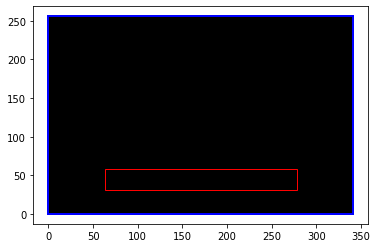

In [168]:
single = train_slide_deck_dataset[0]
draw_bbs(single["shape"], single["ref_slide"])
#print(single)

In [122]:
### path to images folder
root_dir = '/Users/fesiib/Desktop/KIXLab/dev/lecture-design-dataset/dataset/images/'
### path to csv file
csv_file = '/Users/fesiib/Desktop/KIXLab/dev/lecture-design-dataset/dataset/ver123_schema.csv'

dataset = pd.read_csv(csv_file)
img_data = process_fitvid_dataset(dataset, root_dir)

division = int(args.train_portion * len(img_data))

train_dataset = FitVidDataset(
    img_data=slice_dict(img_data, 0, division),
    root_dir=root_dir,
    transform = transforms.Compose([
        Rescale(256),
        RandomCrop(128),
        ToTensor(),
    ])
)
test_dataset = FitVidDataset(
    img_data=slice_dict(img_data, division, len(img_data)),
    root_dir=root_dir,
    transform = transforms.Compose([
        Rescale(256),
        RandomCrop(128),
        ToTensor(),
    ])
)

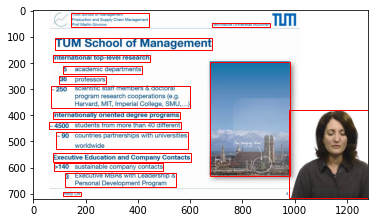

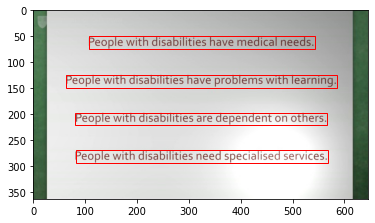

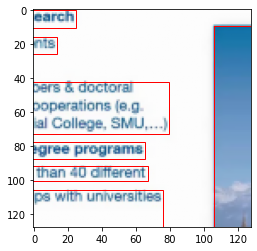

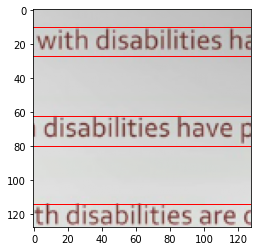

In [15]:
train_dataset.show_image(1)
test_dataset.show_image(0)
sample = train_dataset[1]
draw_image(sample['image'], sample['labels'])

sample = test_dataset[0]
draw_image(sample['image'], sample['labels'])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

In [17]:
class Model1(mask_rcnn):
    def __init__(self):
        super(Model1, self).__init__(make_layers(cfg['vgg16']))

        self.numclass = 21

        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout2d()

        # fc layers in vgg are all converted into conv layers.
        #################################
        ## P1(a). Write your code here ##
        #################################
        self.fc6_conv = nn.Conv2d(512, 4096, 7)
        self.fc7_conv = nn.Conv2d(4096, 4096, 1)

        # Prediction layer with 1x1 convolution layer.
        #################################
        ## P1(b). Write your code here ##
        #################################
        self.classify_conv = nn.Conv2d(4096, self.numclass, 1)

        # Learnable upsampling layers in FCN model.
        #################################
        ## P1(c). Write your code here ##
        #################################
        self.upsample_conv = nn.ConvTranspose2d(self.numclass, self.numclass, 64, 32, bias=False)
        # initialize deconv layer with bilinear upsampling.
        self._initialize_weights()

    def load_pretrained(self, pretrained_model):
        self.features = pretrained_model.features
        fc6 = pretrained_model.classifier[0]
        fc7 = pretrained_model.classifier[3]

        #################################
        ## P1(d). Write your code here ##
        #################################
        fc6_weight = fc6.weight.clone().view_as(self.fc6_conv.weight)
        fc6_bias = fc6.bias.clone().view_as(self.fc6_conv.bias)
        fc7_weight = fc7.weight.clone().view_as(self.fc7_conv.weight)
        fc7_bias = fc7.bias.clone().view_as(self.fc7_conv.bias)

        self.fc6_conv.weight.data.copy_(fc6_weight)
        self.fc6_conv.bias.data.copy_(fc6_bias)
        self.fc7_conv.weight.data.copy_(fc7_weight)
        self.fc7_conv.bias.data.copy_(fc7_bias)

    def vgg_layer_forward(self, x, indices):
        output = x
        start_idx, end_idx = indices
        for idx in range(start_idx, end_idx):
            output = self.features[idx](output)
        return output

    def vgg_forward(self, x):
        out = {}
        layer_indices = [0, 5, 10, 17, 24, 31]
        for layer_num in range(len(layer_indices)-1):
            x = self.vgg_layer_forward(x, layer_indices[layer_num:layer_num+2])
            out[f'pool{layer_num+1}'] = x
        return out

    def forward(self, x):
        # Padding for aligning to the input size
        padded_x = F.pad(x, [100, 100, 100, 100], "constant", 0)
        vgg_features = self.vgg_forward(padded_x)
        vgg_pool5 = vgg_features['pool5'].detach()
        vgg_pool4 = vgg_features['pool4'].detach()
        vgg_pool3 = vgg_features['pool3'].detach()

        #################################
        ## P1(e). Write your code here ##
        #################################

        out = self.dropout(self.relu(self.fc6_conv(vgg_pool5)))
        out = self.dropout(self.relu(self.fc7_conv(out)))
        out = self.classify_conv(out)
        out = self.upsample_conv(out)

        H, W = x.shape[-2], x.shape[-1]
        out = transforms.functional.crop(out, 9, 9, H, W)
        return out

    # initialize transdeconv layer with bilinear upsampling.
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)


TypeError: module() takes at most 2 arguments (3 given)